## Advanced Sentinel-2 image processing, statistics, and plots

This advanced Notebook builds on the beginner Notebook and shows some extended data processing and statistical tools on Sentinel-2 TOC reflectance data. After the data have been read, it is shown how to make transects through the data. Further, the following functionalities will be highlighted:

- Status Map filtering
- compute advanced statistics
- retrieve statistics from shape file
- build stack for RGB + time series
- extract time series

Let's start again with importing the required packages.

In [1]:
import rasterio                                         #for conventiently reading GeoTiff files
from rasterio.windows import Window                     #enables reading only a subset of the loaded file
import matplotlib.pyplot as mplot                       #standard matplotlib module
from mpl_toolkits.axes_grid1 import make_axes_locatable #this module is needed to resize the colorbar to the plot size
import glob                                             #module for searching dirs/files
import datetime as dt                                   #for datetime calculations and plot labels
import numpy as np  
import os
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

We load Sentinel-2 20 m TOC reflectance for the 0.704 $\mu$m (RED) band.

In [2]:
#filename of the Sentinel-2 image we will work on, B05=RED
f_red = '/data/MTDA/TERRASCOPE_Sentinel2/TOC_V2/2017/05/26/S2A_20170526T105031_31UES_TOC_V200/S2A_20170526T105031_31UES_TOC-B05_20M_V200.tif'

#read the files with rasterio and print some attributes
with rasterio.open(f_red, 'r') as data:
    d_red = data.read(1).astype(float)   
print(np.nanmin(d_red), np.nanmax(d_red))

1.0 32767.0


After reading the data, we will first mask out all NoData values, as well as negative TOC reflectances, which are physically impossible. After this screening is done, we can compute the TOC NDVI.  

In [3]:
#TBD: read the nodata and scaling factor from the files' metadata
d_red[(d_red == 32767) | (d_red < 0)] = np.nan

#apply the scaling factor
d_red = d_red * 0.0001
print(np.nanmin(d_red), np.nanmax(d_red))

0.0001 1.5926


## Status Map filtering
The Sentinel 2 Scene Classification contains among others information on cloud and cloud shadow occurrence and whether a pixel is land or water. Below, the Scene Classification file is read. 
Subsequently, the RED and NIR TOC reflectances will be filtered on land surface only.
More information on the Scene classification and its values can be found in the Sentinel-2 TOC reflectance product [ATBD](https://docs.terrascope.be/DataProducts/Sentinel-2/references/S2_L2A_ATBD_V200.pdf). 


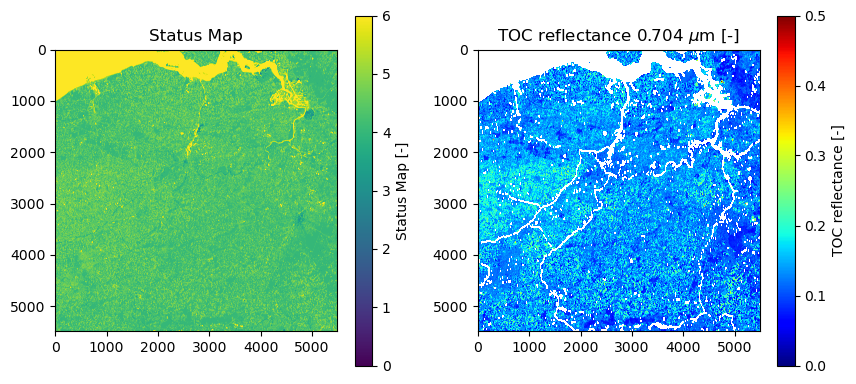

In [4]:
f_status = '/data/MTDA/TERRASCOPE_Sentinel2/TOC_V2/2017/05/26/S2A_20170526T105031_31UES_TOC_V200/S2A_20170526T105031_31UES_SCENECLASSIFICATION_20M_V200.tif'

with rasterio.open(f_status, 'r') as data:
    d_status = data.read(1).astype(int)

mplot.figure(figsize=(10, 10))
mplot.subplot(221)
mplot.imshow(d_status, vmin=0, vmax=6)
mplot.title('Status Map')

cb = mplot.colorbar(aspect=20)  
cb.ax.set_ylabel('Status Map [-]')
cb.ax.tick_params(labelsize=10)

#we are only interested in land surface pixels, so set all sea pixels to NaN
sea = np.where(d_status == 6)
d_red[sea] = np.nan

mplot.subplot(222)
mplot.imshow(d_red, cmap= 'jet', vmin=0., vmax=0.5)
mplot.title('TOC reflectance 0.704 $\mu$m [-]')

cb = mplot.colorbar(aspect=20)  
cb.ax.set_ylabel('TOC reflectance [-]')
cb.ax.tick_params(labelsize=10)


## Advanced Statistics


Below, we give some examples on advanced statistics that can be calculated for the image that was opened above. 
First, we will make a box-whisker plot to show the 5th, 25th, 50th, 75th, and 95th percentile of the RED TOC reflectance over the land surface. 

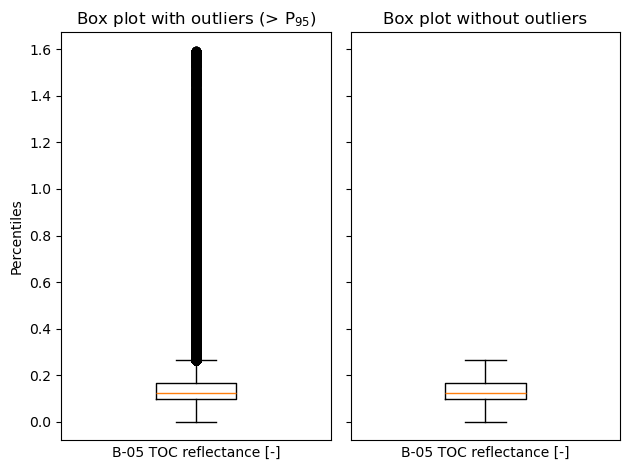

In [5]:
# Take a subset of valid data from d_red and create a single vector

d_red_sub = d_red.flatten()[~np.isnan(d_red.flatten())]

# Create a box plot with outliers
fig,axs=mplot.subplots(nrows=1,ncols=2,sharey=True)

axs[0].boxplot(d_red_sub, widths=0.3, vert=True)
axs[0].set_xlabel('B-05 TOC reflectance [-]')
axs[0].set_ylabel('Percentiles')
axs[0].set_title('Box plot with outliers (> P$_{95}$)')
axs[0].tick_params(
    axis='x',          
    which='both',     
    bottom=False,     
    top=False,         
    labelbottom=False)

# Create a box plot without outliers
axs[1].boxplot(d_red_sub, showfliers=False, widths=0.3, vert=True)
axs[1].set_xlabel('B-05 TOC reflectance [-]')
axs[1].set_title('Box plot without outliers')
axs[1].tick_params(
    axis='x',          
    which='both',     
    bottom=False,     
    top=False,         
    labelbottom=False)

mplot.tight_layout()
mplot.show()


## Image stacking
Images can be stacked in order to 1) construct an RGB image or 2) to construct time series. For limited time series, this can be done by defining and filling a simple 3D numpy array. For more extensive 3D datasets (i.e., hundreds of files or more), the ```xarray``` package is much more efficient in data accessing and indexing. For the 31UES tile, we collect all days with observations for May 2017.

We will start with a 10 m RGB composite for a single date, 26/5/2017, and make a false-colour composite for the Zeebrugge port area.

In [6]:
f_red = '/data/MTDA/TERRASCOPE_Sentinel2/TOC_V2/2017/05/26/S2A_20170526T105031_31UES_TOC_V200/S2A_20170526T105031_31UES_TOC-B04_10M_V200.tif'
f_blu = '/data/MTDA/TERRASCOPE_Sentinel2/TOC_V2/2017/05/26/S2A_20170526T105031_31UES_TOC_V200/S2A_20170526T105031_31UES_TOC-B02_10M_V200.tif'
f_grn = '/data/MTDA/TERRASCOPE_Sentinel2/TOC_V2/2017/05/26/S2A_20170526T105031_31UES_TOC_V200/S2A_20170526T105031_31UES_TOC-B03_10M_V200.tif'
f_nir = '/data/MTDA/TERRASCOPE_Sentinel2/TOC_V2/2017/05/26/S2A_20170526T105031_31UES_TOC_V200/S2A_20170526T105031_31UES_TOC-B08_10M_V200.tif'

#open the files that represent the separate Red, Green, and Blue for the final composite
with rasterio.open(f_red, 'r') as data:
    d_red = data.read(1, window=Window(800, 800, 1200, 1200))
with rasterio.open(f_blu, 'r') as data:
    d_blu = data.read(1, window=Window(800, 800, 1200, 1200))
with rasterio.open(f_grn, 'r') as data:
    d_grn = data.read(1, window=Window(800, 800, 1200, 1200))
with rasterio.open(f_nir, 'r') as data:
    d_nir = data.read(1, window=Window(800, 800, 1200, 1200))

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min) / (array_max - array_min))

# Normalize the bands
redn   = normalize(d_red)
greenn = normalize(d_grn)
bluen  = normalize(d_blu)

Text(0.5, 1.0, 'Zeebrugge port area')

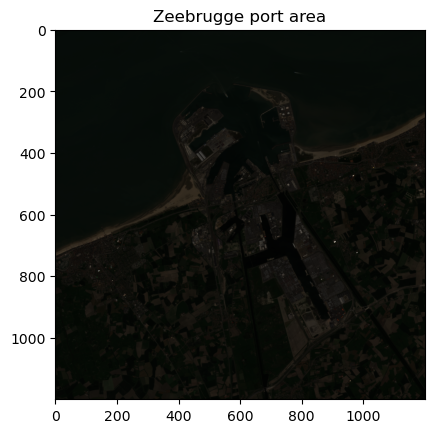

In [7]:
# Create RGB natural color composite

rgb = np.dstack((redn, greenn, bluen))
mplot.imshow(rgb)
mplot.title('Zeebrugge port area')

For the same region, we will calculate the NDVI

In [8]:
d_red = redn * 0.0001
d_nir = d_nir * 0.0001
nir = normalize(d_blu) * 0.0001
d_ndvi = (d_nir - d_red) / (d_nir + d_red)

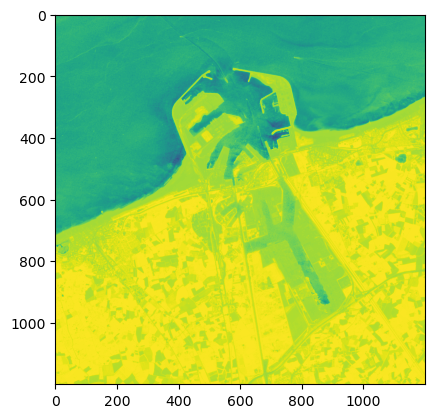

In [9]:
mplot.imshow(d_ndvi)